# **Classification**

## Objectives

* Fit and evaluate a classification model to predict if a mushroom is edible or not.

## Inputs

* outputs/datasets/collection/mushrooms.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modelling pipeline
* Feature importance plot


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety'

---

# Load Data

In [4]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/mushrooms.csv")

print(df.shape)
df.head()

(8124, 23)


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,0,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,1,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


---

# ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

This pipeline is created from the findings of the Data Cleaning and Feature Engineering notebooks. As there is no Data Cleaning tasks that need to be done, it is just referred to as a Feature Engineering pipeline.

In [18]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.selection import SmartCorrelatedSelection
from category_encoders import TargetEncoder
 
variables_to_drop = []

def PipelineFeatureEngineering():
    """ Create data cleaning and feature engineering """

    pipeline_base = Pipeline([
        ("TargetCategoricalEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance"))
    ])

    return pipeline_base

PipelineFeatureEngineering()

Pipeline(steps=[('TargetCategoricalEncoder', TargetEncoder()),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    """ Creates classifier model pipeline """
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for Hyperparameter Optimisation - this class, taken from the model cross validation lessons, will allow performing a hyperparameter grid search to determine the best performing classifier model and it's ideal hyperparameters for the model pipeline.

In [7]:
from sklearn.model_selection import GridSearchCV
import numpy as np

class HyperparameterOptimizationSearch:
    """ 
    Initializes as sets of models and hyperparameters for each model
    Methods:
    fit - fits each of the declared models for each of their stated hyperparameter sets
    score_summary - generates a summary output of each fitted model's performance for comparison purposes
    """
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        """ 
        fits each of the search's models and model hyperparameter sets
        cv controls the number of folds in the cross validation, n_jobs controls processor parallelisation """
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        """ Creates a summation of each models performance to be displayed in a DataFrame """
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['edible'], axis=1),
    df['edible'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6499, 22) (6499,) (1625, 22) (1625,)


## Fit and Transform Train and Test Sets

Using `y_train` as the target input for the `"TargetEncoder"` step, the feature engineering pipeline is fit to and then transforms the Train Set, and then is used to transform the Test Set

In [9]:
pipeline_data_cleaning_feat_eng = PipelineFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train, y_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6499, 17) (6499,) (1625, 17) (1625,)


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/select

---

# Handle Target Imbalance

Check Train Set edibility distribution

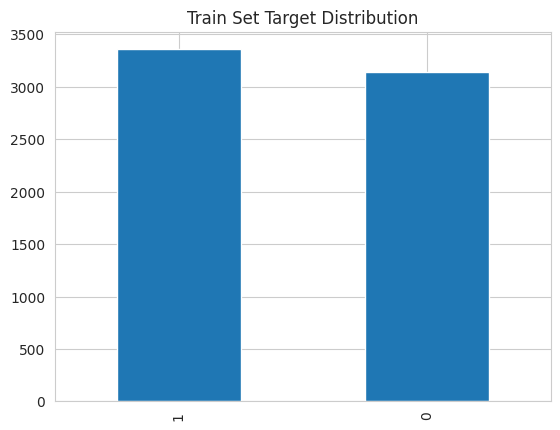

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

It appears the dataset is slightly skewed toward having more edible mushrooms. To balance the target, we use SMOTE (Synthetic Minority Oversampling TEchnique) on the Train Set

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6712, 17) (6712,) (1625, 17) (1625,)


Check Train Set Target distribution after resampling

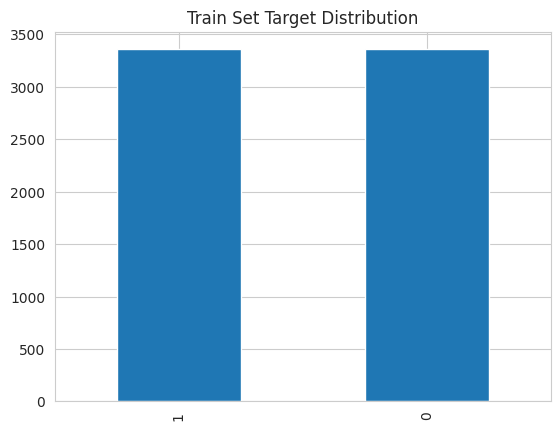

In [12]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

---

# Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm

We define a set of different classifier algorithms to perform a grid search over. The hyperparameters will be left to their defaults, here we wish to find the best algorithm only.

In [19]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Quick GridSearch CV - Binary Classifier. As we need to optimize with respect to the precision and recall on edibility, we will set the scorer to f1_score, a metric that includes the two. 

In [20]:
from sklearn.metrics import make_scorer, f1_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(f1_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be remove


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results - will select `AdaBoostClassifier` as best performing model.

In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
6,AdaBoostClassifier,0.99777,0.999108,1.0,0.001093
3,RandomForestClassifier,0.988218,0.989827,0.992604,0.001491
5,ExtraTreesClassifier,0.988218,0.989827,0.992604,0.001491
0,LogisticRegression,0.986765,0.988077,0.989691,0.001168
1,XGBClassifier,0.98315,0.984599,0.98604,0.001211
2,DecisionTreeClassifier,0.98315,0.984599,0.98604,0.001211
4,GradientBoostingClassifier,0.98315,0.984599,0.98604,0.001211


Define a set of hyperparameters for `AdaBoostClassifier` to perform the grid search over.

In [22]:
models_search = {
    "AdaBoostClassifier":AdaBoostClassifier(random_state=0),
}

params_search = {
    "AdaBoostClassifier":{
        'model__n_estimators': [10, 25, 50, 100, 500],
        'model__learning_rate': [0.01, 0.05, 0.2, 1],
        'model__base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=5)]
    }
}

Extensive GridSearch CV - Binary Classifier. As we need to optimize with respect to the precision and recall on edibility, we will set the scorer to f1_score, a metric that includes the two. 

In [24]:
from sklearn.metrics import make_scorer, f1_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(f1_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Check results

In [25]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__base_estimator,model__learning_rate,model__n_estimators
30,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=3),0.2,10
46,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=5),0.05,25
29,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=3),0.05,500
31,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=3),0.2,25
32,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=3),0.2,50
33,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=3),0.2,100
34,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=3),0.2,500
35,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=3),1,10
36,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=3),1,25
37,AdaBoostClassifier,1.0,1.0,1.0,0.0,DecisionTreeClassifier(max_depth=3),1,50


Get best model name

In [26]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Get parameters for best model

In [27]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__base_estimator': DecisionTreeClassifier(max_depth=3),
 'model__learning_rate': 0.01,
 'model__n_estimators': 500}

Define the best clf pipeline by pulling it from the `HyperparameterOptimizationSearch` search object

In [28]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.01, n_estimators=500,
                                    random_state=0))])

## Assess feature importance

In [29]:
X_train.head()

,cap-shape,cap-surface,cap-color,odor,gill-spacing,gill-size,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,population,habitat
0,0.279035,0.438147,0.558981,0.964374,0.913289,0.699396,0.454675,0.285066,0.700097,0.613947,0.616084,0.516387,0.506375,0.87885,0.790661,0.698318,0.655093
1,0.529735,0.674506,0.686203,0.964374,0.913289,0.699396,0.454675,0.285066,0.700097,0.613947,0.616084,0.516387,0.506375,0.87885,0.790661,1.000000,0.655093
2,0.529735,0.438147,0.686203,1.000000,0.438948,0.699396,0.454675,0.912037,0.700097,0.613947,0.616084,0.516387,0.506375,0.48955,0.790661,0.698318,0.865217
3,0.506100,0.438147,0.686203,0.964374,0.913289,0.699396,0.563159,0.768478,0.700097,0.613947,0.616084,0.516387,0.506375,0.48955,0.367673,0.698318,0.655093
4,0.279035,0.464355,0.413793,0.000000,0.438948,0.112919,0.563159,0.285066,0.700097,0.613947,0.304203,0.516387,0.506375,0.48955,0.367673,0.292561,0.269985


Using current model, can assess feature importance from model `.feature_importances_`

* These are the 9 most important features in descending order. The model was trained on them: 
['cap-color', 'stalk-surface-above-ring', 'odor', 'population', 'gill-size', 'habitat', 'stalk-root', 'stalk-shape', 'gill-spacing']


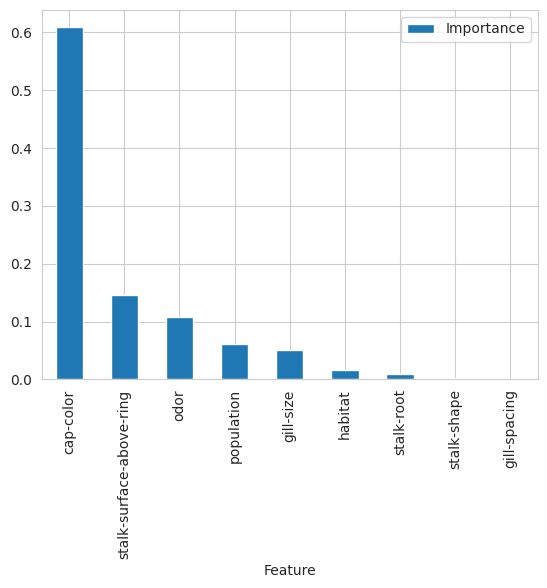

In [30]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [31]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):
    """ Displays the confusion matrix and classification report for a give model """
    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    """ Calls confusion_matrix_and_report for the train and test set """
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation: We cross check with metrics defined in the ML business case

* A precision of 1 on predicting whether a mushroom is edible
* A recall of at least 0.9 on predicting if a mushroom is edible

In [32]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map=['poisonous', 'edible']
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual poisonous Actual edible
Prediction poisonous             3356             0
Prediction edible                   0          3356


---  Classification Report  ---
              precision    recall  f1-score   support

   poisonous       1.00      1.00      1.00      3356
      edible       1.00      1.00      1.00      3356

    accuracy                           1.00      6712
   macro avg       1.00      1.00      1.00      6712
weighted avg       1.00      1.00      1.00      6712
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual poisonous Actual edible
Prediction poisonous              773             0
Prediction edible                   0           852


---  Classification Report  ---
              precision    recall  f1-score   support

   poisonous       1.00      1.00      1.00       773
      edible       1.00      1.00      1.00       852

    accuracy                   

The model performs at the required level of precision and recall on the test set, and therefore is useable for the business case.

## Push files to Repo

Will generate following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Features importance plot

In [33]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_edible/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_edible/v1'


## Train Set

Variables are already transformed, and SMOTE has been applied

In [34]:
print(X_train.shape)
X_train.head()

(6712, 17)


,cap-shape,cap-surface,cap-color,odor,gill-spacing,gill-size,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,population,habitat
0,0.279035,0.438147,0.558981,0.964374,0.913289,0.699396,0.454675,0.285066,0.700097,0.613947,0.616084,0.516387,0.506375,0.87885,0.790661,0.698318,0.655093
1,0.529735,0.674506,0.686203,0.964374,0.913289,0.699396,0.454675,0.285066,0.700097,0.613947,0.616084,0.516387,0.506375,0.87885,0.790661,1.000000,0.655093
2,0.529735,0.438147,0.686203,1.000000,0.438948,0.699396,0.454675,0.912037,0.700097,0.613947,0.616084,0.516387,0.506375,0.48955,0.790661,0.698318,0.865217
3,0.506100,0.438147,0.686203,0.964374,0.913289,0.699396,0.563159,0.768478,0.700097,0.613947,0.616084,0.516387,0.506375,0.48955,0.367673,0.698318,0.655093
4,0.279035,0.464355,0.413793,0.000000,0.438948,0.112919,0.563159,0.285066,0.700097,0.613947,0.304203,0.516387,0.506375,0.48955,0.367673,0.292561,0.269985


In [35]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [36]:
y_train

0       1
1       1
2       1
3       1
4       0
       ..
6707    0
6708    0
6709    0
6710    0
6711    0
Name: edible, Length: 6712, dtype: int64

In [37]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

Variables are already transformed

In [38]:
print(X_test.shape)
X_test.head()

(1625, 17)


,cap-shape,cap-surface,cap-color,odor,gill-spacing,gill-size,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,population,habitat
380,0.529735,0.464355,0.552516,2.143344e-09,0.438948,0.112919,0.454675,0.768478,0.700097,0.613947,0.616084,0.516387,0.506375,0.48955,0.790661,0.698318,0.261745
3641,0.506100,0.464355,0.558981,9.643739e-01,0.438948,0.699396,0.563159,0.509804,0.700097,1.000000,1.000000,0.516387,0.506375,0.48955,0.790661,0.621444,0.596338
273,0.529735,0.464355,0.372738,1.000000e+00,0.438948,0.699396,0.454675,0.912037,0.700097,0.613947,0.616084,0.516387,0.506375,0.48955,0.790661,1.000000,0.865217
1029,0.529735,0.438147,0.686203,9.643739e-01,0.913289,0.699396,0.563159,0.768478,0.700097,0.613947,0.616084,0.516387,0.506375,0.48955,0.367673,1.000000,0.655093
684,0.529735,0.674506,0.552516,9.643739e-01,0.438948,0.699396,0.563159,0.509804,0.700097,0.309953,0.616084,0.516387,0.506375,0.48955,0.790661,0.292561,0.596338


In [39]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [40]:
y_test

380     0
3641    1
273     1
1029    1
684     1
       ..
3535    1
1643    1
6494    0
6       1
3175    1
Name: edible, Length: 1625, dtype: int64

In [41]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

Will save 2 pipelines:
* Both will be used sequentially to predict Live Data.
* To predict on Train Set/Test Set, only use pipeline_clf since the data is already processed.

Pipeline for Data Cleaning and Feature Engineering

In [42]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('TargetCategoricalEncoder',
                 TargetEncoder(cols=['cap-shape', 'cap-surface', 'cap-color',
                                     'bruises', 'odor', 'gill-attachment',
                                     'gill-spacing', 'gill-size', 'gill-color',
                                     'stalk-shape', 'stalk-root',
                                     'stalk-surface-above-ring',
                                     'stalk-surface-below-ring',
                                     'stalk-color-above-ring',
                                     'stalk-color-below-ring', 'veil-type',
                                     'veil-color', 'ring-number', 'ri...
                                          variables=['cap-shape', 'cap-surface',
                                                     'cap-color', 'bruises',
                                                     'odor', 'gill-attachment',
                                                     'gill-spacing',
       

In [43]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_edible/v1/clf_pipeline_data_cleaning_feat_eng.pkl']

Pipeline for feature scaling and model

In [44]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.01, n_estimators=500,
                                    random_state=0))])

In [45]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_edible/v1/clf_pipeline_model.pkl']

## Feature Importance plot

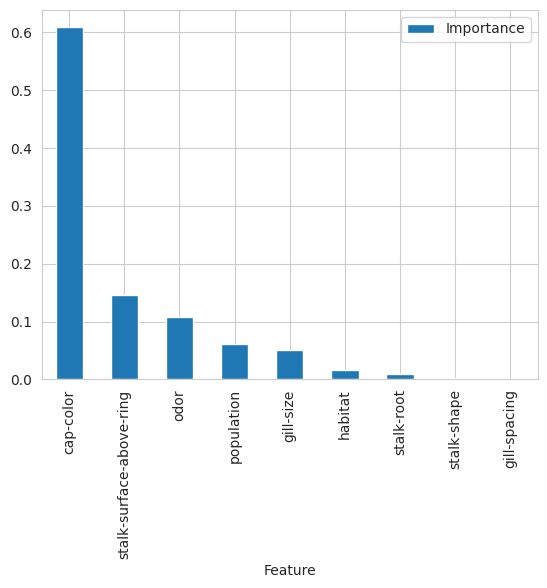

In [46]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

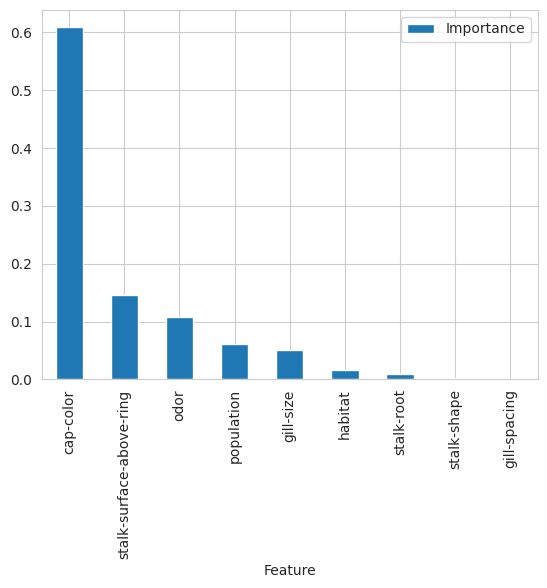

In [47]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')